<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Convolutional Neural Networks and Computer Vision with TensorFlow
This notebook will cover the following with TensorFlow:
* Getting a dataset to work with.
* Architecture of convolutional neural network
* A quick end-to-end example
* Steps in modelling for binary image classifications with CNNs
  * Becoming one with data
  * Preparing the data for modelling.
  * Creating a CNN model ( starting with baseline )
  * Evaluating a model
  * Improving a model
  * Making a prediction with trained model
* Steps in modelling for multi-class image classification with CNNs
  * Same as above but with a multi-class dataset



## Get the data
The images we will be using are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 real world images of food dishes.

In [1]:
import zipfile
# Downlad the zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

#unzip the zip file
zip_ref = zipfile.ZipFile('pizza_steak.zip','r')
zip_ref.extractall()
zip_ref.close()

--2023-07-06 00:39:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  24.0MB/s    in 5.6s    

2023-07-06 00:39:39 (18.6 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



Inspect the data [Becoming one with data](https://karpathy.github.io/2019/04/25/recipe/)

In [2]:
# File structure
!ls pizza_steak

test  train


In [3]:
!pip install tree

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 6.2 MB/s eta 0:00:00
  Created wheel for tree: filename=Tree-0.2.4-py3-none-any.whl size=7859 sha256=349e78bd10f7dbb9c1aa4cc272f7b412b31ef5ee899ca74f32b4b7ea8b47cef9
  Stored in directory: /root/.cache/pip/wheels/06/1e/8c/73b3a97f37991dc90603631567511071513ee3c6d819393232
Successfully built tree


In [4]:
import os
for dirpath, dirnames,filenames in os.walk("pizza_steak"):
  print(f" There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

 There are 2 directories and 0 images in pizza_steak
 There are 2 directories and 0 images in pizza_steak/train
 There are 0 directories and 750 images in pizza_steak/train/steak
 There are 0 directories and 750 images in pizza_steak/train/pizza
 There are 2 directories and 0 images in pizza_steak/test
 There are 0 directories and 250 images in pizza_steak/test/steak
 There are 0 directories and 250 images in pizza_steak/test/pizza


In [5]:
# Get the class names
## the class names are the name of the folders containing respective images.

import pathlib
import numpy as np

def get_classnames(train_dir: str) -> list[str]:

  """
    This function will return the name of the folers in training directory.
    Args:
      train_dir(str): The name of train directory

    Returns:
      directory_names(list[str]): The name of the directories in the train_dir directory.
  """
  data_dir = pathlib.Path(train_dir)
  folder_names = sorted([item.name for item in data_dir.glob("*")])
  return folder_names


In [6]:
classnames = get_classnames("pizza_steak/train")
classnames

['pizza', 'steak']

> 🔑note: Whenever working with data, it's always good to visualize as much as possible. The first few steps of any project is becoming one with data. **Visualize**, **visualize**, **visualize**

Let's write a function to plot a random image and its shape

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# function to view a random image from given a target directory and a target class

def view_random_image(target_dir,target_class):
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  print(f" Showing image {random_image[0]} from {target_folder}")
  print(f" Shape of the image {img.shape}")
  plt.title(target_class)
  plt.axis("off")
  return img

 Showing image 3479936.jpg from pizza_steak/train/pizza
 Shape of the image (332, 512, 3)


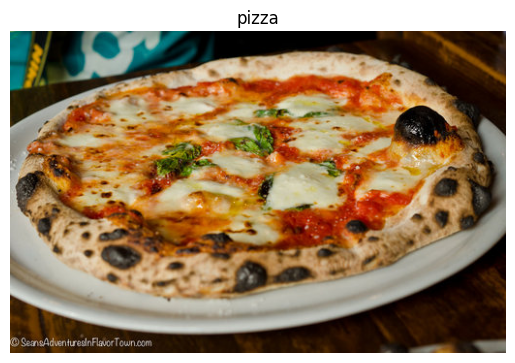

In [8]:
img = view_random_image("pizza_steak/train/","pizza")

In [9]:
img.max(),img.min()

(255, 0)

In [10]:
img/255

array([[[0.3254902 , 0.55686275, 0.29803922],
        [0.31372549, 0.55294118, 0.31764706],
        [0.2745098 , 0.5372549 , 0.3254902 ],
        ...,
        [0.21960784, 0.18039216, 0.21568627],
        [0.28627451, 0.2745098 , 0.34901961],
        [0.3372549 , 0.3372549 , 0.43921569]],

       [[0.08235294, 0.45098039, 0.34901961],
        [0.07843137, 0.44705882, 0.35294118],
        [0.0627451 , 0.44313725, 0.36470588],
        ...,
        [0.20784314, 0.17254902, 0.19215686],
        [0.27058824, 0.25490196, 0.31372549],
        [0.31764706, 0.30980392, 0.39215686]],

       [[0.        , 0.42352941, 0.45098039],
        [0.        , 0.42352941, 0.44313725],
        [0.        , 0.42352941, 0.43529412],
        ...,
        [0.2       , 0.16078431, 0.16470588],
        [0.25098039, 0.23137255, 0.25882353],
        [0.28235294, 0.2745098 , 0.3254902 ]],

       ...,

       [[0.29803922, 0.16470588, 0.        ],
        [0.33333333, 0.18823529, 0.01176471],
        [0.34117647, 0

# An end-to-end example

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set seed
tf.random.set_seed(42)

# Preprocess data ( get all the pixel values of a image within 0,1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up the train and test directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# import data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir
                                               ,batch_size=32
                                               ,target_size=(224,224)
                                               ,class_mode="binary"
                                               ,seed=42)
valid_data = valid_datagen.flow_from_directory(test_dir
                                               ,batch_size=32
                                               ,target_size=(224,224)
                                               ,class_mode="binary"
                                               ,seed=42)

# Create an CNN (TinyVGG) model same as https://poloclub.github.io/cnn-explainer/

model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=(3,3)
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.MaxPool2D(pool_size=2
                               ,padding="valid")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.MaxPool2D(2)
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# Fit the model with train & valid data
history_1 = model_1.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5
#                        ,verbose=0
                        )


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 33s 361ms/step - loss: 0.5559 - accuracy: 0.7220 - val_loss: 0.4803 - val_accuracy: 0.7740
Epoch 2/5
47/47 [==============================] - 11s 230ms/step - loss: 0.4555 - accuracy: 0.8040 - val_loss: 0.3640 - val_accuracy: 0.8480
Epoch 3/5
47/47 [==============================] - 11s 225ms/step - loss: 0.4357 - accuracy: 0.8067 - val_loss: 0.3919 - val_accuracy: 0.8420
Epoch 4/5
47/47 [==============================] - 10s 215ms/step - loss: 0.3733 - accuracy: 0.8387 - val_loss: 0.3316 - val_accuracy: 0.8760
Epoch 5/5
47/47 [==============================] - 11s 233ms/step - loss: 0.3164 - accuracy: 0.8673 - val_loss: 0.3386 - val_accuracy: 0.8740


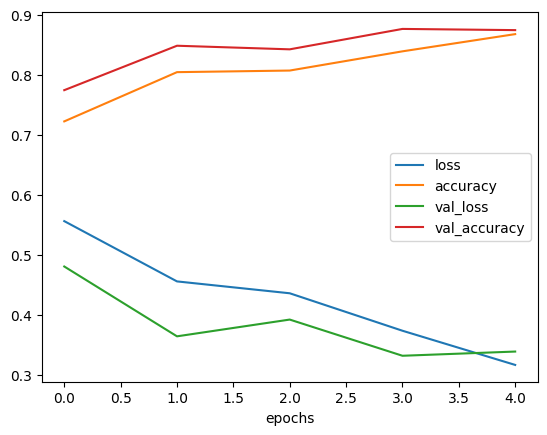

In [12]:
import pandas as pd
pd.DataFrame(history_1.history).plot(xlabel="epochs");

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

Let's try to fit our earlier model from `learn_tf_003` notebook. The model with 4 layers

In [14]:
# set seed
tf.random.set_seed(42)

# build the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3))
    ,tf.keras.layers.Dense(4,activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(4,activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])

# compile the model
model_2.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# Fit the model
history_2 = model_2.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5)

Epoch 1/5
47/47 [==============================] - 13s 247ms/step - loss: 0.9800 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 10s 214ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 10s 213ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 12s 262ms/step - loss: 0.6932 - accuracy: 0.4880 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 12s 258ms/step - loss: 0.6932 - accuracy: 0.4840 - val_loss: 0.6931 - val_accuracy: 0.5000


<Axes: xlabel='epochs'>

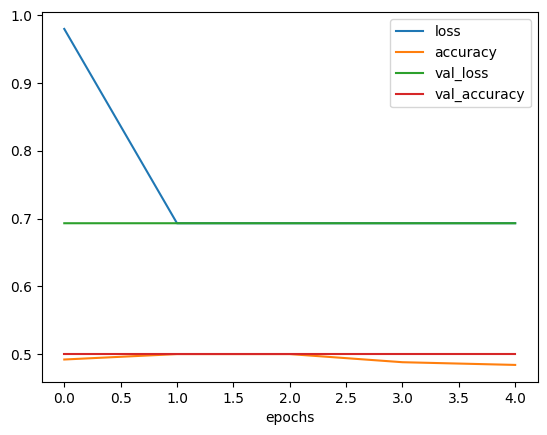

In [15]:
pd.DataFrame(history_2.history).plot(xlabel="epochs")

In [16]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


The last model didn't work . Let's add one more layer and increase the number of neurons( also known as hidden units ) in each dense layer from 4 to 100.

In [17]:
# set random seed
tf.random.set_seed(42)

# build the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3))
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# compile the model
model_3.compile(loss= tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_3 = model_3.fit(train_data
            ,epochs=5
            ,steps_per_epoch=len(train_data)
            ,validation_data=valid_data
            ,validation_steps=len(valid_data)
            )

Epoch 1/5
47/47 [==============================] - 12s 219ms/step - loss: 3.2912 - accuracy: 0.6393 - val_loss: 0.8604 - val_accuracy: 0.7200
Epoch 2/5
47/47 [==============================] - 9s 195ms/step - loss: 1.0691 - accuracy: 0.6807 - val_loss: 0.6931 - val_accuracy: 0.7740
Epoch 3/5
47/47 [==============================] - 10s 211ms/step - loss: 0.7983 - accuracy: 0.7433 - val_loss: 0.7147 - val_accuracy: 0.7200
Epoch 4/5
47/47 [==============================] - 11s 234ms/step - loss: 0.6915 - accuracy: 0.7327 - val_loss: 0.6940 - val_accuracy: 0.7160
Epoch 5/5
47/47 [==============================] - 10s 216ms/step - loss: 0.6947 - accuracy: 0.7400 - val_loss: 0.4829 - val_accuracy: 0.7940


In [18]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


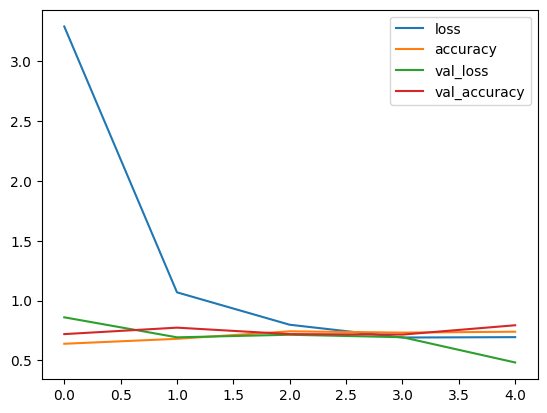

In [19]:
pd.DataFrame(history_3.history).plot();

# Binary Classification

## Step 1 : Be one with Data

 Showing image 2951831.jpg from pizza_steak/train/pizza
 Shape of the image (512, 512, 3)
 Showing image 2890573.jpg from pizza_steak/train/steak
 Shape of the image (512, 512, 3)


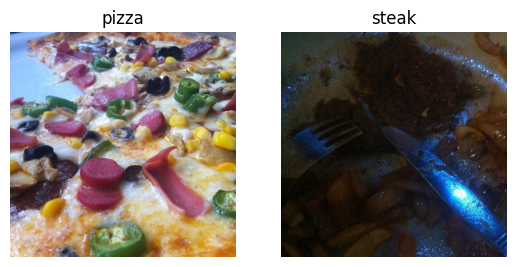

In [20]:
# visualize random images
plt.figure()
plt.subplot(1,2,1)
pizza_img=view_random_image("pizza_steak/train/","pizza")
plt.subplot(1,2,2)
steak_img=view_random_image("pizza_steak/train/","steak")

## Step 2 : Preprocess the data
1. Create the train and test directory paths
2. Create batch: Usually a batch size of 32 works in almost all cases.


In [21]:
#1. Define the train and test directory paths
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"


In [22]:
#2. Create Batch:
# To create batch first we need to create an instance of ImageDataGenerator for each dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from their respective folders using `.flow_from_directory` method of ImageDataGenerator
train_data = train_datagen.flow_from_directory(directory=train_dir
                                                    ,target_size=(224,224)
                                                    ,class_mode="binary"
                                                    ,batch_size=32)
test_data = test_datagen.flow_from_directory(directory=test_dir
                                                   ,target_size=(224,224)
                                                   ,class_mode="binary"
                                                   ,batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [23]:
# ImageDataGenerator is deprecated. Let's give a try of following the suggestion of using tf.keras.utils.image_dataset_from_directory` and transforming the output
# `tf.data.Dataset` with preprocessing layers
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_dir
                                                            ,image_size=(224,224)
                                                            ,batch_size=32
                                                            ,labels="inferred"
                                                            ,label_mode="binary")

test_dataset = tf.keras.utils.image_dataset_from_directory(directory=test_dir
                                                           ,image_size=(224,224)
                                                           ,batch_size=32
                                                           ,labels="inferred"
                                                           ,label_mode="binary")

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [24]:
images,labels = train_data.next()
len(images), len(labels)

(32, 32)

## Step 3 : Build the model

In [25]:
# set seeds
tf.random.set_seed(42)

# build the model
model_4 =  tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=3
                           ,strides=1
                           ,padding="valid"
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_4 = model_4.fit(train_data
            ,steps_per_epoch=len(train_data)
            ,validation_data=test_data
            ,validation_steps=len(test_data)
            ,epochs=5)

Epoch 1/5
47/47 [==============================] - 14s 244ms/step - loss: 0.8396 - accuracy: 0.6980 - val_loss: 0.4125 - val_accuracy: 0.8240
Epoch 2/5
47/47 [==============================] - 11s 228ms/step - loss: 0.4103 - accuracy: 0.8253 - val_loss: 0.3632 - val_accuracy: 0.8560
Epoch 3/5
47/47 [==============================] - 11s 229ms/step - loss: 0.3144 - accuracy: 0.8760 - val_loss: 0.3686 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 11s 227ms/step - loss: 0.1803 - accuracy: 0.9373 - val_loss: 0.3510 - val_accuracy: 0.8580
Epoch 5/5
47/47 [==============================] - 10s 212ms/step - loss: 0.0704 - accuracy: 0.9833 - val_loss: 0.3664 - val_accuracy: 0.8460


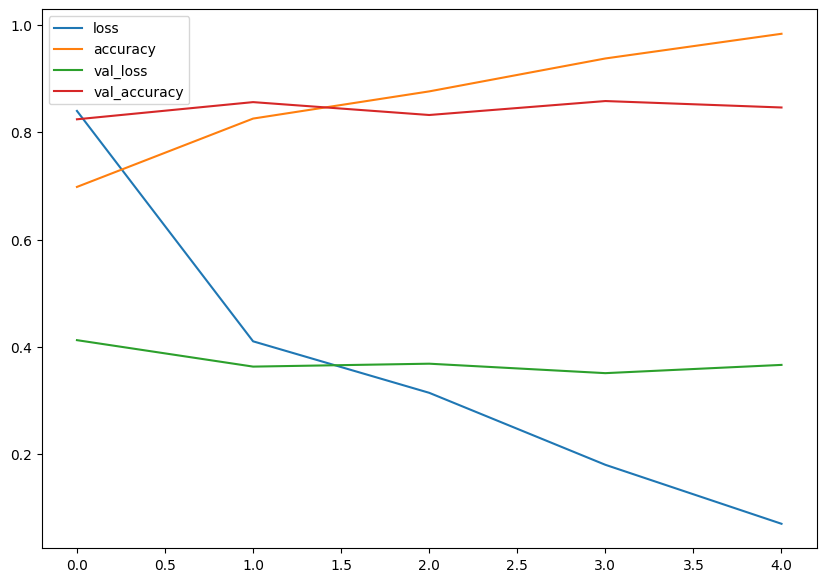

In [26]:
# Plot the loss curve
pd.DataFrame(history_4.history).plot(figsize=(10,7));

In [27]:
print(tf.__version__)

2.12.0


🇹 The current code is using `ImageDataGenerator` to create data for training and validation. We should change it to `tf.keras.utils.image_dataset_from_directory` as suggested in API docs.

Function to separate the loss and accuracy curve.

In [42]:
def plot_loss_curve(history):
  """
    Returns separate loss curves for training and validation metrics
  """

  loss = history["loss"]
  val_loss = history["val_loss"]

  acc=history["accuracy"]
  val_acc = history["val_accuracy"]

  epochs = range(len(history["loss"]))

  # Plot loss
  plt.figure()
  plt.plot(epochs,loss,label="loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,acc,label="accuracy")
  plt.plot(epochs,val_acc,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

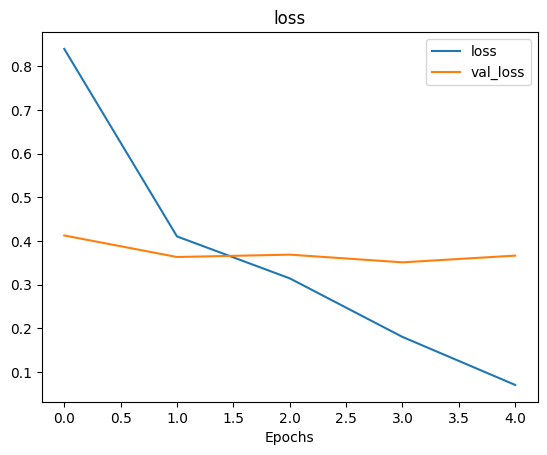

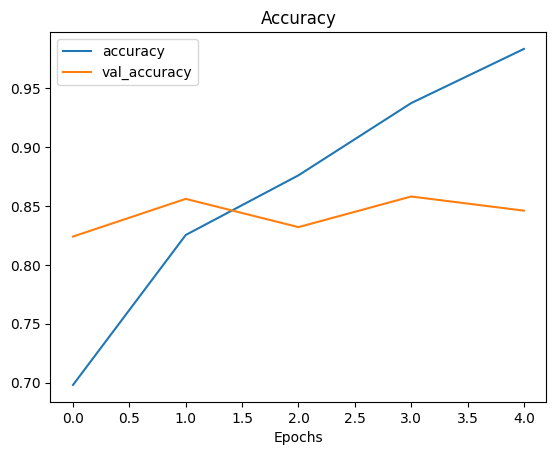

In [43]:
plot_loss_curve(history_4.history)

In [38]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


Let's build 2 more models

* A convnet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A convnet with max pooling and data augmentation

In [40]:
from keras.layers import MaxPool2D
from tensorflow.python.ops.gen_nn_ops import MaxPool
from keras.layers.convolutional.conv2d_transpose import Conv2D
# A model with max pooling

#set seed
tf.random.set_seed(42)

# build the model

model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=3
                           ,padding="valid"
                           ,strides=1
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model

model_5.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_5 = model_5.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5)



Epoch 1/5
47/47 [==============================] - 13s 221ms/step - loss: 0.6233 - accuracy: 0.6567 - val_loss: 0.5148 - val_accuracy: 0.7620
Epoch 2/5
47/47 [==============================] - 10s 224ms/step - loss: 0.4789 - accuracy: 0.7807 - val_loss: 0.3776 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 10s 222ms/step - loss: 0.4313 - accuracy: 0.8093 - val_loss: 0.3619 - val_accuracy: 0.8520
Epoch 4/5
47/47 [==============================] - 11s 224ms/step - loss: 0.4060 - accuracy: 0.8200 - val_loss: 0.3502 - val_accuracy: 0.8540
Epoch 5/5
47/47 [==============================] - 12s 268ms/step - loss: 0.3661 - accuracy: 0.8440 - val_loss: 0.3334 - val_accuracy: 0.8520


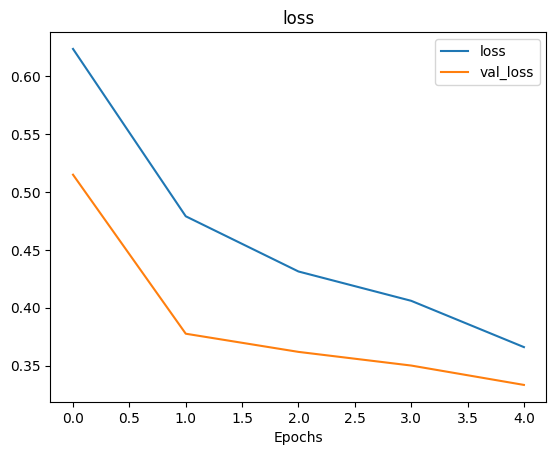

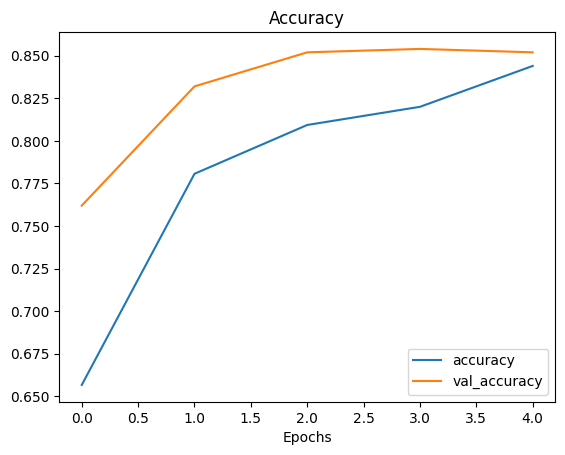

In [44]:
plot_loss_curve(history_5.history)

In [45]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 10)      

#### Perform Data augmentation

In [48]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1./255
                                          ,rotation_range=20
                                          ,shear_range=0.2
                                          ,zoom_range=0.2
                                          ,width_shift_range=0.2
                                          ,height_shift_range=0.2
                                          ,horizontal_flip=True)

# Create ImageDataGenerator instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create ImageDataGenerator instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [51]:
print(f"Augmented training data")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir
                                                                ,target_size=(224,224)
                                                                ,batch_size=32
                                                                ,class_mode="binary"
                                                                ,shuffle=False)

print(f"Non-Augmented training data")
train_data = train_datagen.flow_from_directory(train_dir
                                               ,target_size=(224,224)
                                               ,batch_size=32
                                               ,class_mode="binary"
                                               ,shuffle=False)

print(f"Non-Augmented test data")
test_data = test_datagen.flow_from_directory(test_dir
                                             ,target_size=(224,224)
                                             ,batch_size=32
                                             ,class_mode="binary"
                                            )

Augmented training data
Found 1500 images belonging to 2 classes.
Non-Augmented training data
Found 1500 images belonging to 2 classes.
Non-Augmented test data
Found 500 images belonging to 2 classes.


In [52]:
images,labels= train_data.next()
augmented_images,augmented_labels=train_data_augmented.next()

 Random number : 26


(-0.5, 223.5, 223.5, -0.5)

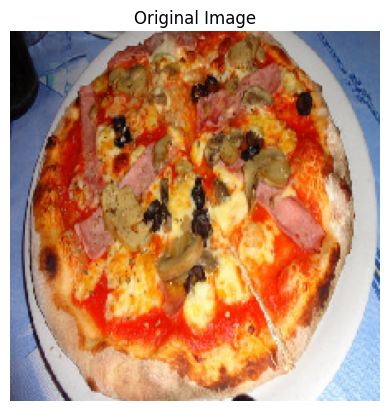

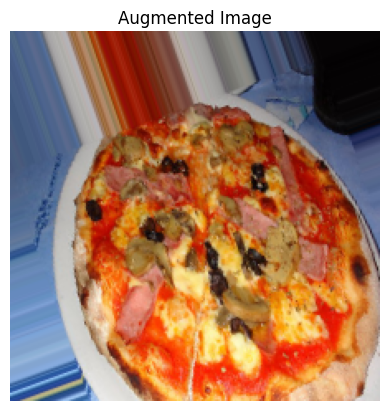

In [58]:
#show a random image
random_number = random.randint(0,31)
print(f" Random number : {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original Image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented Image")
plt.axis(False)